In [1]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import dataloader

In [2]:
transformation_operation = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

In [3]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transformation_operation)
val_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transformation_operation)

In [4]:
num_classes = 10
batch_size = 64
num_channels = 1
img_size = 28
patch_size = 7
num_patches = (img_size // patch_size)**2
embedding_dim = 64
attention_heads = 4
transformer_blocks = 4
mlp_hidden_nodes = 128
learning_rate = 0.001
epochs = 5

In [5]:
train_loader = dataloader.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = dataloader.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [6]:
class PatchEmbedding(nn.Module):
    def __init__(self):
        super().__init__()
        self.patch_embed = nn.Conv2d(num_channels, embedding_dim, kernel_size=patch_size, stride=patch_size)
    
    def forward(self, x):
        x = self.patch_embed(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)
        return x

In [7]:
class TransformerEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_norm1 = nn.LayerNorm(embedding_dim)
        self.layer_norm2 = nn.LayerNorm(embedding_dim)
        self.multihead_attention = nn.MultiheadAttention(embedding_dim, attention_heads, batch_first=True)
        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim, mlp_hidden_nodes),
            nn.GELU(),
            nn.Linear(mlp_hidden_nodes, embedding_dim),
        )
    
    def forward(self, x):
        residual1 = x
        x = self.layer_norm1(x)
        x = self.multihead_attention(x, x, x)[0]
        x = x + residual1
        residual2 = x
        x = self.layer_norm2(x)
        x = self.mlp(x)
        x = x + residual2
        return x

In [8]:
class MLP_Head(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_norm1 = nn.LayerNorm(embedding_dim)
        self.mlp_head = nn.Linear(embedding_dim, num_classes)

    def forward(self, x):
        x = self.layer_norm1(x)
        x = self.mlp_head(x)
        return x

In [9]:
class VisionTransformer(nn.Module):
    def __init__(self):
        super().__init__()
        self.patch_embeddin = PatchEmbedding()
        self.cls_token = nn.Parameter(torch.randn(1,1,embedding_dim))
        self.position_embedding = nn.Parameter(torch.randn(1, num_patches+1, embedding_dim))
        self.transformer_blocks = nn.Sequential(*[TransformerEncoder() for _ in range(transformer_blocks)])
        self.mlp_head = MLP_Head()

    def forward(self, x):
        x = self.patch_embeddin(x)
        B = x.size(0)
        class_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((class_tokens, x), dim = 1)
        x = x + self.position_embedding
        x = self.transformer_blocks(x)
        x = x[:,0]
        x = self.mlp_head(x)
        return x

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VisionTransformer().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
criterion =  nn.CrossEntropyLoss()

In [11]:
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_epoch = 0
    total_epoch = 0
    print(f"\nEpoch {epoch+1}")
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct = (preds == labels).sum().item()
        accuracy = 100.0*correct/labels.size(0)
        correct_epoch += correct
        total_epoch += labels.size(0)
        if batch_idx % 100 == 0:
            print(f"Batch {batch_idx+1:3d}: Loss = {loss.item():.4f}, Accuracy = {accuracy:.2f}%")
    epoch_acc = 100.0*correct_epoch/total_epoch
    print(f"==> Epoch {epoch+1} Summary: Total Loss = {total_loss:.4f}, Accuracy = {epoch_acc:.2f}%")


Epoch 1
Batch   1: Loss = 2.4911, Accuracy = 10.94%
Batch 101: Loss = 0.5681, Accuracy = 82.81%
Batch 201: Loss = 0.2279, Accuracy = 92.19%
Batch 301: Loss = 0.2273, Accuracy = 90.62%
Batch 401: Loss = 0.2049, Accuracy = 95.31%
Batch 501: Loss = 0.1859, Accuracy = 96.88%
Batch 601: Loss = 0.1244, Accuracy = 98.44%
Batch 701: Loss = 0.1299, Accuracy = 95.31%
Batch 801: Loss = 0.1619, Accuracy = 95.31%
Batch 901: Loss = 0.0978, Accuracy = 96.88%
==> Epoch 1 Summary: Total Loss = 327.8138, Accuracy = 89.15%

Epoch 2
Batch   1: Loss = 0.0922, Accuracy = 98.44%
Batch 101: Loss = 0.1108, Accuracy = 98.44%
Batch 201: Loss = 0.0378, Accuracy = 98.44%
Batch 301: Loss = 0.1228, Accuracy = 96.88%
Batch 401: Loss = 0.0951, Accuracy = 98.44%
Batch 501: Loss = 0.2228, Accuracy = 90.62%
Batch 601: Loss = 0.0565, Accuracy = 98.44%
Batch 701: Loss = 0.1934, Accuracy = 93.75%
Batch 801: Loss = 0.1017, Accuracy = 95.31%
Batch 901: Loss = 0.1861, Accuracy = 95.31%
==> Epoch 2 Summary: Total Loss = 119.64

In [12]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

val_acc = 100.0*correct/total
print(f"\n==> Valitation Accuracy: {val_acc:.2f}%")


==> Valitation Accuracy: 97.60%


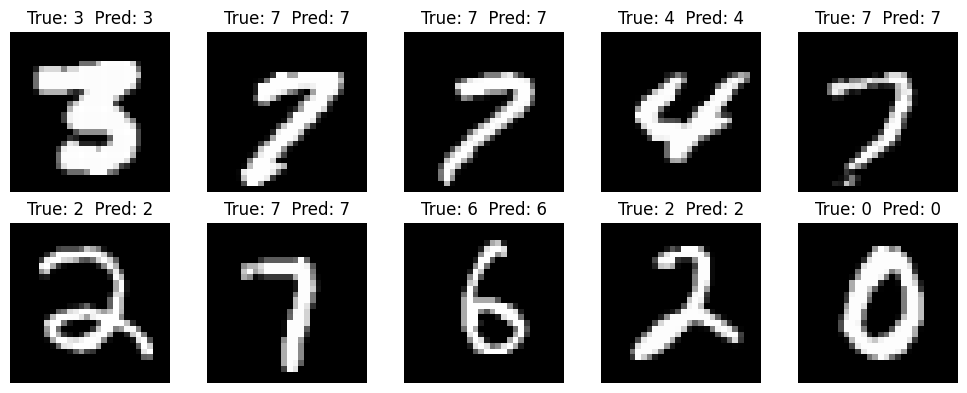

In [17]:
import matplotlib.pyplot as plt
import random

# grab one batch from validation loader
images_batch, labels_batch = next(iter(val_loader))
images_batch, labels_batch = images_batch.to(device), labels_batch.to(device)

model.eval()
with torch.no_grad():
    outputs_batch = model(images_batch)
    preds_batch = outputs_batch.argmax(dim=1)

# randomly select 10 indices from the batch
batch_size = images_batch.size(0)
random_indices = random.sample(range(batch_size), 10)

# plot a 2x5 grid (random 10 images)
n_rows, n_cols = 2, 5
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))

for i, idx in enumerate(random_indices):
    ax = axes[i // n_cols, i % n_cols]
    img = images_batch[idx].cpu().squeeze(0)  # shape 28x28
    ax.imshow(img, cmap='gray')
    ax.set_title(f"True: {labels_batch[idx].item()}  Pred: {preds_batch[idx].item()}")
    ax.axis('off')

plt.tight_layout()
plt.show()